In [1]:
import networkx as nx
import random as rng
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import csv

In [18]:
class Ant:

    def __init__(self, position, path):
        self.path = []
        self.position = position
    
    def pickup_deliver(self, g, orders):
        
        # return home when no orders left
        if orders == []:
            if self.position != 1:
                self.path.append((self.position, 1))
                self.position = 1

        else:
            paths = []
            for i in orders:
                if (self.position,i[0]) not in paths:
                    paths.append((self.position,i[0]))

            if (g[i]["weight"] == 0 for i in paths):
                for i in paths:
                    g.edges[i]["weight"] = 1


            # move ant on randomly chosen path to pickup location according to pheremone weights
            path = rng.choices(paths, (g.edges[paths[i]]["weight"] for i in range(0,len(paths))))[0]
            self.path.append(path)
            self.position = path[1]

            for i in paths:
                    g.edges[i]["weight"] = 0

            # randomly choose order to deliver according to pheremone paths
            paths = []

            for i in orders:
                if i[0] == self.position:
                    paths.append(i)

            if (paths[i]["weight"] == 0 for i in paths):
                for i in paths:
                    g.edges[i]["weight"] = 1

            path = rng.choices(paths, (g.edges[paths[i]]["weight"] for i in range(0,len(paths))))[0]
            self.path.append(path)
            self.position = path[1]

            for i in paths:
                    g.edges[i]["weight"] = 0

            orders.remove(self.path[-1])

In [19]:
class Colony:

    def __init__(self,n, evap, pher, orders):
        self.ants = []
        self.evap = evap
        self.pher = pher
        for i in range(0,n): self.ants.append(Ant(1,[]))
        self.orders = orders

    def move(self, g):
        for i in self.ants:
            i.pickup_deliver(g, self.orders)

    def fulfill(self, g):
        while self.orders != []:
                self.move(g)

        self.move(g)
            

        solution = []

        for i in self.ants:
            solution.append(i.path)

        return solution

    def update(self, g, sol):

        for i in g.edges:
            g.edges[i]["weight"] = (1-self.evap)* g.edges[i]["weight"]
        
        for i in sol:
            for j in i:
                g.edges[j]["weight"] += self.pher/g.edges[j]["distance"]
                


In [20]:
M = widgets.FloatSlider(min=0.0,max=100.0,step=1, value=10, description = "K (pheremone)")
U = widgets.FloatSlider(min=0.0,max=1.0,step=0.01, value=0.5, description = "V (evaporation rate")

In [21]:
path = "forest_sets_with_csv/data/mod_forestset4_nodes.csv"

rows = []
with open(path, newline='') as csvfile:
    nodes = csv.reader(csvfile)
    next(nodes)

    for row in nodes:
        rows.append(row)

node_coords = []
node_types = []

for i in rows:
    node_coords.append((int(i[0]),int(i[1])))
    node_types.append(i[2])

In [22]:
path = "forest_sets_with_csv/data/mod_forestset4_orders.csv"

rows = []
with open(path, newline='') as csvfile:
    orders = csv.reader(csvfile)
    next(orders)

    for row in orders:
        rows.append(row)

order_tuples = []

for i in rows:
    order_tuples.append((int(i[0]),int(i[1])))

In [23]:
g = nx.DiGraph()
g.add_nodes_from(range(1,len(node_coords)+1))

for i in g.nodes():
    for j in g.nodes():
        g.add_edge(i,j, weight=1, orders = 0)

for i in order_tuples:
    g.edges[i[0],i[1]]["orders"] +=1


for i in g.nodes():
    g.nodes[i]['x'] = node_coords[i-1][0]
    g.nodes[i]['y'] = node_coords[i-1][1]
    g.nodes[i]["type"] = node_types[i-1]

for i in g.edges():
    g.edges[i]["distance"] = np.sqrt((g.nodes[i[1]]["x"] - g.nodes[i[0]]["x"])**2 + (g.nodes[i[1]]["y"] - g.nodes[i[0]]["y"])**2)


In [46]:
display(M)
display(U)

FloatSlider(value=48.0, description='K (pheremone)', step=1.0)

FloatSlider(value=1.0, description='V (evaporation rate', max=1.0, step=0.01)

Total distance traversed: 54476979.251894556


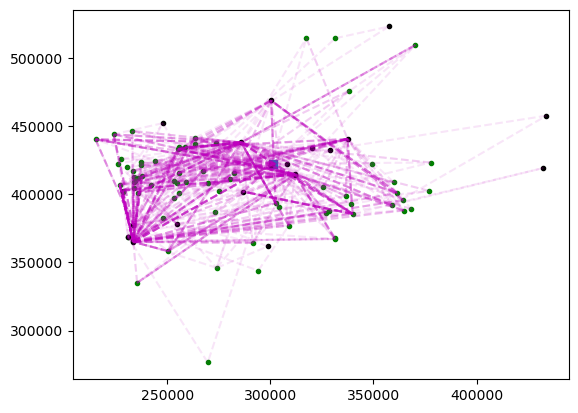

In [50]:
orders = order_tuples.copy()
iteration_num = 10
colony = Colony(40, M.value, U.value, orders)

for i in range(iteration_num):
    orders = order_tuples.copy()

    colony.__init__(40, M.value, U.value, orders)
    
    solution = colony.fulfill(g)

    colony.update(g, solution)

solution = colony.fulfill(g)
x_forests = []
y_forests = []

x_sawmills = []
y_sawmills = []


for i in g.nodes():
    if g.nodes[i]["type"] == "forest": 
        x_forests.append(g.nodes[i]['x'])
        y_forests.append(g.nodes[i]['y'] )

    if g.nodes[i]["type"] == "sawmill": 
        x_sawmills.append(g.nodes[i]['x'])
        y_sawmills.append(g.nodes[i]['y'] )

fig, ax = plt.subplots()


def plot_path(path):
    for i in path:
        ax.plot([g.nodes[i[0]]['x'], g.nodes[i[1]]['x']], [g.nodes[i[0]]['y'], g.nodes[i[1]]['y']], color="m", linestyle="--", alpha=0.1)

for i in range(len(solution)):
    plot_path(solution[i])

ax.scatter(g.nodes[1]['x'],g.nodes[1]['y'], marker="s")
ax.scatter(x_forests,y_forests, c="green", marker=".")
ax.scatter(x_sawmills,y_sawmills, c="black", marker=".")

def distance(path):
    distance = 0
    for i in path:
        distance += g.edges[i]["distance"]
    
    return distance


print("Total distance traversed: " + str(sum(map(distance, solution))))